### DataSet: https://drive.google.com/drive/folders/1xXAnHJoZ85IOhBbP6CyBZdqupzih2naC?usp=drive_link

### Download the dataset and preprocess

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Augment the dataset by applying various image transformations and then split it into training and test sets.

In [174]:
import tensorflow as tf


img_height = 224
img_width = 224

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_ds = train_datagen.flow_from_directory(
  '/content/gdrive/MyDrive/Sample',
  subset="training",
  batch_size=32,
  target_size=(img_height, img_width),
  )

val_ds =  val_datagen.flow_from_directory(
  '/content/gdrive/MyDrive/Sample',
  subset="validation",
  target_size=(img_height, img_width),
  batch_size=32,
  )

Found 8 images belonging to 1 classes.
Found 2 images belonging to 1 classes.


### Plot some Images

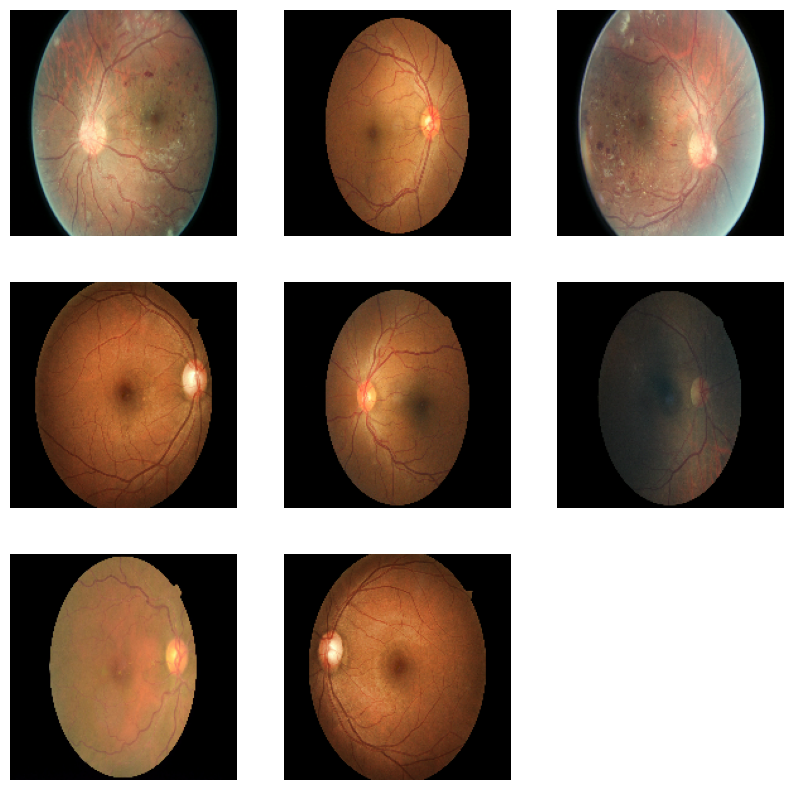

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

### Define the Mirrored Strategy, to train the model using multiple devices or machines

In [10]:
strategy = tf.distribute.MirroredStrategy()

# This prints the number of GPU devices that will be used in the distributed training.
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

Number of devices: 1


### Design a CNN architecture that can effectively extract features from the input data.
### Implement checkpoints to save the model's weights during training, allowing for easy recovery in case of interruptions.

> Add blockquote



In [188]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

  model = tf.keras.Sequential([
      # Defines a sequential model, indicating that each layer has exactly one input tensor and one output tensor.
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
      # Convolutional layer with 32 filters, a kernel size of 3, ReLU activation, and the expected input shape.
      tf.keras.layers.MaxPooling2D(),
      # Max pooling layer for downsampling the feature maps.
      tf.keras.layers.Flatten(),
      # Flattens the input. Does not affect the batch size.
      tf.keras.layers.Dense(64, activation='relu'),
      # Fully connected layer with 64 units and ReLU activation.
      tf.keras.layers.Dense(1, activation='sigmoid')
      # Output layer with 10 units (for the 10 classes of digits). No activation function is specified here because
      # this will be a logits output, which will be used with a loss function that applies softmax internally.
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/path/to/saved_model.keras',
    monitor='val_accuracy', mode='max',
    save_best_only=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=10,  callbacks=[model_checkpoint])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 100s 100s/step - accuracy: 0.3750 - loss: 0.7189 - val_accuracy: 1.0000 - val_loss: 1.3013e-12
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 2.9456e-21 - val_accuracy: 1.0000 - val_loss: 1.0199e-20
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 1.7650e-33 - val_accuracy: 1.0000 - val_loss: 3.3384e-27
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 1.1552e-32
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 2.1758e-37
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0000e+0

### Save the trained model for future use.

In [189]:
model.save('/path/to/saved_model.keras')

In [110]:
 early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=2)

In [111]:
 callbacks=[model_checkpoint_cb, early_stopping_cb]

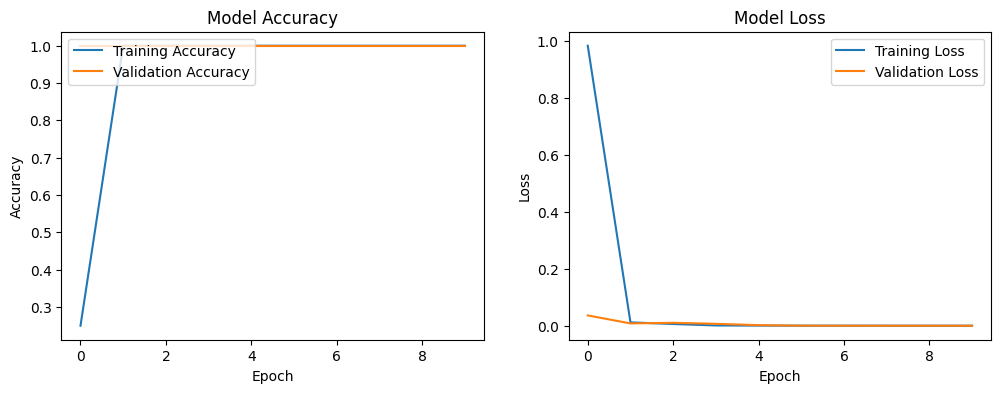

In [112]:
import matplotlib.pyplot as plt

# Extract history data
history_dict = history.history

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

### Deploy the saved model.

In [190]:
loaded_model = tf.keras.models.load_model('/path/to/saved_model.keras', custom_objects=None, compile=True, safe_mode=True)
# Loads the model from the saved path. This operation reconstitutes the model from its saved state, allowing it to be used for inference, further training, or evaluation without requiring access to the original code that built the model.

loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

eval_loss, eval_acc = loaded_model.evaluate(train_ds)
print('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00
Eval loss: 0.0, Eval Accuracy: 1.0
